In [1]:
import sys
from pathlib import Path
from typing import Dict, Any, Tuple
from torch.utils.data import DataLoader

PROJECT_ROOT = Path.cwd()
sys.path.append(str(PROJECT_ROOT))

PYTHONWARNINGS = "ignore:In 2.9.*:UserWarning:torchaudio._backend.utils,ignore:'pin_memory'.*:UserWarning:torch.utils.data.dataloader"

current_dir = Path.cwd()
project_root = current_dir.parent.parent.parent
data_root = str(project_root / "src" / "datasets" / "esc50" / "data")

print(f"Current directory: {current_dir}")
print(f"Project root: {project_root}")
print(f"Data root: {data_root}")

Current directory: /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/notebooks/esc50
Project root: /Users/glbrlb/PycharmProjects/Msc/LMU_S4
Data root: /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data


In [ ]:
from src.types.task_protocol import TaskProtocol

"""Imports and Task Definition"""
import os
import torch

from src.datasets.esc50.esc50_dataset import make_esc50_loaders
from src.models.v2.build_model import BlockConfig, build_model
from src.train_utils.trainer import Trainer
from src.utils.common import set_seed


class ESC50Task(TaskProtocol):
    """
    ESC-50 environmental sound classification task.
    - 50-class classification
    - Input: Audio spectrograms (mel-spectrograms)
    - 5-fold cross-validation
    """
    problem_type: str = "multiclass"

    def make_loaders(
        self,
        data_root: str,
        batch_size: int = 64,
        num_workers: int = 4,
        **kwargs
    ) -> Tuple[DataLoader, DataLoader, DataLoader]:
        """
        Returns: (train_loader, val_loader, test_loader)
        with x: (B, T, D), y: (B,) for classification
        """
        fold_val = kwargs.get("fold_val", 1)
        feature = kwargs.get("feature", "melspec")
        sample_rate = kwargs.get("sample_rate", 16000)
        n_mels = kwargs.get("n_mels", 128)
        hop_length = kwargs.get("hop_length", 160)
        n_fft = kwargs.get("n_fft", 512)
        target_num_frames = kwargs.get("target_num_frames", 500)
        augment = kwargs.get("augment", True)

        loaders = make_esc50_loaders(
            data_root=data_root,
            batch_size=batch_size,
            num_workers=num_workers,
            fold_val=fold_val,
            feature=feature,
            sample_rate=sample_rate,
            n_mels=n_mels,
            hop_length=hop_length,
            n_fft=n_fft,
            target_num_frames=target_num_frames,
            augment=augment,
            download=False
        )

        if isinstance(loaders, (list, tuple)) and len(loaders) == 3:
            return loaders
        else:
            train_loader, val_loader = loaders
            return train_loader, val_loader, val_loader

    def infer_input_dim(self, args: Dict[str, Any]) -> int:
        feature = args.get("feature", "melspec")
        return args.get("n_mels", 128) if feature == "melspec" else 1

    def infer_num_classes(self, args: Dict[str, Any]) -> int:
        return 50

    def infer_theta(self, args: Dict[str, Any]) -> int:
        return args.get("target_num_frames", 500)


def create_block_cfg_ctor(
    core: str,
    dropout: float,
    mlp_ratio: float,
    droppath_final: float,
    layerscale_init: float,
    residual_gain: float,
    pool: str,
    # LMU-specific params
    memory_size: int = 256,
    theta: int = 500,
):
    """Create a block config constructor for LMU."""

    def block_cfg_ctor(theta_in: int) -> BlockConfig:
        return BlockConfig(
            kind=core,
            memory_size=memory_size,
            theta=theta_in,
            dropout=dropout,
            mlp_ratio=mlp_ratio,
            droppath_final=droppath_final,
            layerscale_init=layerscale_init,
            residual_gain=residual_gain,
            pool=pool,
        )
    return block_cfg_ctor

In [ ]:
"""Configuration"""
set_seed(42)

args: Dict[str, Any] = {
    # data
    "data_root": data_root,
    "batch": 32,  # MPS-optimized
    "data_loader_kwargs": {
        "num_workers": 0,  # Critical for Mac
        "fold_val": 1,
        "feature": "melspec",
        "sample_rate": 16000,
        "n_mels": 128,
        "hop_length": 160,
        "n_fft": 512,
        "target_num_frames": 500,
        "augment": True,
        "pin_memory": False,
        "persistent_workers": False,
    },

    # training - Standardized for fair comparison
    "epochs": 100,
    "lr": 1e-3,
    "wd": 1e-4,
    "amp": True,
    "save_dir": "./runs/esc50_lmu_trainer",
    "warmup_epochs": 10,
    "patience": 10,
    "min_delta": 0.0,
    "early_key": "acc",

    # model scaffold - Standardized for fair comparison
    "d_model": 256,
    "depth": 6,
    "dropout": 0.1,
    "mlp_ratio": 2.0,
    "droppath_final": 0.05,
    "layerscale_init": 1e-2,
    "residual_gain": 1.0,
    "pool": "mean",

    # LMU-specific parameters
    "core": "lmu",
    "memory_size": 256,
    "theta": 500,
}

# Create block config constructor
args["block_cfg_ctor"] = create_block_cfg_ctor(
    core=args["core"],
    dropout=args["dropout"],
    mlp_ratio=args["mlp_ratio"],
    droppath_final=args["droppath_final"],
    layerscale_init=args["layerscale_init"],
    residual_gain=args["residual_gain"],
    pool=args["pool"],
    memory_size=args["memory_size"],
    theta=args["theta"],
)

# Device selection
if torch.backends.mps.is_available():
    args["device"] = torch.device("mps")
    print("🚀 Using MPS (Apple Silicon)")
elif torch.cuda.is_available():
    args["device"] = torch.device("cuda")
    print("🚀 Using CUDA")
else:
    args["device"] = torch.device("cpu")
    args["amp"] = False
    print("⚠️ Using CPU")

In [ ]:
"""Train the model"""
def main() -> Trainer:
    task = ESC50Task()

    if torch.backends.mps.is_available():
        torch.mps.set_per_process_memory_fraction(0.9)
        os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

    trainer = Trainer(args=args, task=task, model_builder=build_model)

    best_metric, ckpt_path = trainer.fit()
    print(f"✅ Done. Best {trainer.early_key}={best_metric:.4f} @ {ckpt_path}")
    return trainer

In [ ]:
trainer = main()

In [4]:
"""Load checkpoint and evaluate"""
def load_trainer_from_checkpoint(
    checkpoint_path: str,
    args: Dict[str, Any],
    task: TaskProtocol
) -> Trainer:
    """Load trainer from checkpoint."""
    checkpoint = torch.load(checkpoint_path, map_location=args["device"])
    trainer = Trainer(args=args, task=task, model_builder=build_model)
    trainer.model.load_state_dict(checkpoint["model"])
    if "optimizer" in checkpoint:
        trainer.opt.load_state_dict(checkpoint["optimizer"])
    if "scheduler" in checkpoint:
        trainer.scheduler.load_state_dict(checkpoint["scheduler"])
    if "history" in checkpoint:
        trainer.history = checkpoint["history"]
    print(f"✅ Loaded checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f"📊 Val metrics: {checkpoint.get('val', {})}")
    return trainer


trainer = load_trainer_from_checkpoint(
    checkpoint_path=os.path.join(args["save_dir"], "best.pt"),
    args=args,
    task=ESC50Task()
)

ESC-50 check under /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data. Checking /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data/ESC-50-master ...


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


ESC-50 check under /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data. Checking /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data/ESC-50-master ...


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: divide by zero encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: overflow encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:326: RuntimeWarning: invalid value encountered in matmul
  m, s = pick_pade_structure(Am)
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: divide by zero encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/linalg/_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/scipy/li

✅ Loaded checkpoint from epoch 52
📊 Val metrics: {'loss': 2.379335403442383, 'time_s': 4.776509082999837, 'acc': 0.495}


In [ ]:
"""Visualize training history"""
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(16, 6))
plt.plot(trainer.history["train_acc"], label="train_acc", linewidth=2.5)
plt.plot(trainer.history["val_acc"], label="val_acc", linewidth=2.5)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.title("S4 Model - Accuracy", fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(16, 6))
plt.plot(trainer.history["train_loss"], label="train_loss", linewidth=2.5)
plt.plot(trainer.history["val_loss"], label="val_loss", linewidth=2.5)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.title("S4 Model - Loss", fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ESC-50 check under /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data. Checking /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data/ESC-50-master ...


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


ESC-50 check under /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data. Checking /Users/glbrlb/PycharmProjects/Msc/LMU_S4/src/datasets/esc50/data/ESC-50-master ...


/Users/glbrlb/PycharmProjects/Msc/LMU_S4/.venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(



VALIDATION SET RESULTS
Overall accuracy: 0.4950

Top-10 and Bottom-10 Classes by Performance:
Top per-class accuracies:
01. class_9                   : 0.875
02. class_27                  : 0.875
03. class_19                  : 0.875
04. class_11                  : 0.875
05. class_49                  : 0.750
06. class_34                  : 0.750
07. class_29                  : 0.750
08. class_0                   : 0.750
09. class_39                  : 0.750
10. class_18                  : 0.750
Bottom per-class accuracies:
01. class_25                  : 0.000
02. class_36                  : 0.125
03. class_2                   : 0.125
04. class_13                  : 0.250
05. class_35                  : 0.250
06. class_4                   : 0.250
07. class_5                   : 0.250
08. class_7                   : 0.250
09. class_41                  : 0.250
10. class_16                  : 0.250


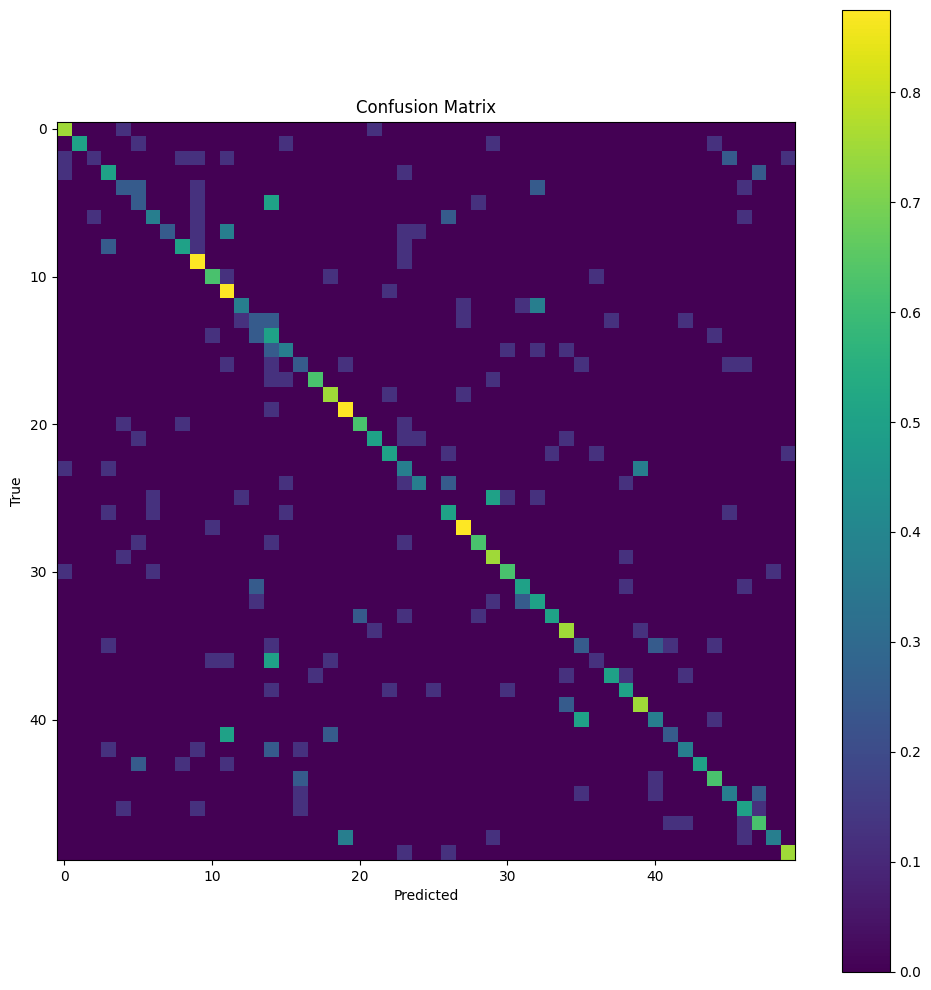

In [5]:
"""Detailed evaluation with confusion matrix"""
from src.eval.infer import predict_loader
from src.eval.metrics import confusion_matrix
from src.eval.report import print_basic_report, plot_confusion, print_per_class
from src.utils.common import amp_autocast

_, val_loader, _ = trainer.task.make_loaders(
    data_root=args["data_root"],
    batch_size=args["batch"],
    **args["data_loader_kwargs"]
)

logits, labels = predict_loader(
    trainer.model, val_loader, trainer.device, amp_autocast, trainer.amp
)

print("\n" + "="*50 + "\nVALIDATION SET RESULTS\n" + "="*50)
print_basic_report(logits, labels)

cm = confusion_matrix(logits, labels, num_classes=50)
plot_confusion(cm, class_names=None, normalize=True, figsize=(10, 10))
print("\nTop-10 and Bottom-10 Classes by Performance:")
print_per_class(cm, class_names=None, top_k=10)

In [6]:
from src.utils.common import print_model_details

print_model_details(model=trainer.model)


                            MODEL DETAILS                             

                             ARCHITECTURE                             
----------------------------------------------------------------------
Model Type: SeqClassifier
Core Layer Type: LMUCoreAdapter
Number of Blocks: 6

                              PARAMETERS                              
----------------------------------------------------------------------
Total parameters:              3,212,088
Trainable parameters:          3,212,088
Non-trainable parameters:              0
Model size (MB):                   12.25

                           MODEL ATTRIBUTES                           
----------------------------------------------------------------------

                           MODULE BREAKDOWN                           
----------------------------------------------------------------------
proj                           Linear                             33,024
blocks                         ModuleList